<h1>Predicting the loss rate of a wireless link</h1>
This notebook works on the data collected at the ENS Lyon and the INSA Lyon as part of the wireless networking section in the ANR Concerto project. The goal is to first study the data and see which performance metrics can be useful, and to then build a prediction model for them.

Every line in the data files loaded here represents the average of 100ms of experimental data. 
The measurements were taken at the ENS Lyon (1H, 2nd, 3rd) and the INSA Lyon (Anechoic chamber) by varying the distance between two IEEE 802.11ac APs acting as source and destination. There is a continuous, saturated UDP stream from the source AP to the destination. 

Because of the nature of the cards and system in use, a third AP placed close to the destination AP is acting as monitor and capturing the exchanged frames. This introduces measurement errors due to the fact that what the monitor captures and what the destination captures will not be the exact same stream of frames. To circumvent this issue, we have considered several different ways of computing the channel quality based on both the data frames and the ACK frames captured by the monitor. These computations are detailed later in the notebook. 

The goal is to build a robust model capable of predicting the link quality that 1) provides an accurate prediction of the link quality and that 2) requires few input features. 

Some of the data will be removed as it seems to produce no measurable lossrate (Anechoic chamber with movement) or because there are too few samples to learn any conclusive rules (Anechoic chamber with obstacle).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors

%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 13

In [2]:
# define custom colormaps
norm = matplotlib.colors.Normalize(-1,1)
# summer colors (yellow to dar blue with orange and purple)
color1 = '#ffa600'
color2 = '#ff6361'
color3 = '#bc5090'
color4 = '#003f5c'
colors_summer = [[norm(-1.0), color1],
          [norm(-0.6), color2],
          [norm( 0.6), color3],
          [norm( 1.0), color4]]
cmap_summer = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_summer)

# summer colors divergent
color1d = '#003f5c'
color2d = '#4f697e'
color3d = '#8a96a2'
color4d = '#c6c6c6'
color5d = '#e1a9a3'
color6d = '#f38982'
color7d = '#ff6361'
color8dyellow = '#ffc16a' #an extra shade of yellow
color9dgray = '#2a2b2d'
colors_summer = [[norm(-1.0), color1d],
          [norm(-0.6), color2d],
          [norm(-0.3), color3d],
          [norm( 0.0), color4d],
          [norm( 0.3), color5d],
          [norm( 0.6), color6d],
          [norm( 1.0), color7d]]
cmap_summer_divergent = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_summer)
colorlist_summer_divergent = [color1d, color7d, color3d, color5d, color2d, color6d, color4d, color8dyellow, color9dgray]
# salmon-blue colormap
color1sb = '#54bebe'
color2sb = '#8ad6bb'
color3sb = '#c2eabd'
color4sb = '#f9fdca'
color5sb = '#f9d491'
color6sb = '#ffa46e'
color7sb = '#ff6c6c'
colors_salmon_blue = [[norm(-1.0), color1sb],
          [norm(-0.6), color2sb],
          [norm(-0.3), color3sb],
          [norm( 0.0), color4sb],
          [norm( 0.3), color5sb],
          [norm( 0.6), color6sb],
          [norm( 1.0), color7sb]]
cmap_salmon_blue = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_salmon_blue)
colorlist_salmon_blue = [color1sb, color7sb, color3sb, color5sb, color2sb, color6sb, color4sb]

sns.set_palette(colorlist_summer_divergent)

<h4>Read the data and assign the scenario name</h4>

In [3]:
df1 = pd.read_csv('1H/complete_data.csv', sep='\t')
df1['Scenario'] = 'First floor'
df2 = pd.read_csv('2nd/complete_data.csv', sep='\t')
df2['Scenario'] = 'Second floor'
df3 = pd.read_csv('3rd/complete_data.csv', sep='\t')
df3['Scenario'] = 'Third floor'
df4 = pd.read_csv('CA/complete_data.csv', sep='\t')
df4['Scenario'] = 'Anechoic ch.'
df5 = pd.read_csv('CA_move/complete_data.csv', sep='\t')
df5['Scenario'] = 'Anechoic mvmnt'
df6 = pd.read_csv('CA_doubles/complete_data.csv', sep='\t')
df6['Scenario'] = 'Anechoic ch.'
df7 = pd.read_csv('1H_obstacle/complete_data.csv', sep='\t')
df7['Scenario'] = 'Obstacle 1H'
df8 = pd.read_csv('2nd_obstacle/complete_data.csv', sep='\t')
df8['Scenario'] = 'Obstacle 2nd'
df9 = pd.read_csv('3rd_obstacle/complete_data.csv', sep='\t')
df9['Scenario'] = 'Obstacle 3rd'
df10 = pd.read_csv('CA_obstacle/complete_data.csv', sep='\t')
df10['Scenario'] = 'Anechoic obstacle'
df11 = pd.read_csv('2nd_unsaturated/complete_data.csv', sep='\t')
df11['Scenario'] = 'Unsaturated 2nd'

In [4]:
df1.head()

,time,mcs,nss,bw,rssi,throughput_monitor,datarate,pktlost_ack,nbpkt_monitor,retry,nbpkt_ack,pktlost_seq_initial,pktlost_seq_new,bad_fcs,distance,antenna,LoS,Scenario
0,8.100307,5.0,3.0,80.0,-62.0628,39374100.0,780.0,19.0,1321.0,76.0,1307.0,8.0,3243.0,0.0,17,left,1,First floor
1,8.200425,5.0,3.0,80.0,-62.1569,37883600.0,780.0,11.0,1268.0,34.0,1275.0,7.0,0.0,0.0,17,left,1,First floor
2,8.300426,5.0,3.0,80.0,-62.1972,40036700.0,780.0,36.0,1339.0,75.0,1301.0,11.0,0.0,0.0,17,left,1,First floor
3,8.400429,5.0,3.0,80.0,-62.2085,39397100.0,780.0,12.0,1314.0,46.0,1320.0,12.0,0.0,0.0,17,left,1,First floor
4,8.500672,5.0,3.0,80.0,-62.4337,38501300.0,780.0,16.0,1289.0,50.0,1276.0,7.0,0.0,0.0,17,left,1,First floor


<h4>The features:</h4>
<li>Time: timestamp of the event in seconds</li>
<li>MCS: Modulation and Coding Scheme (MCS) index (relates to the data rate, higher MCS index means higher data rate)</li>
<li>NSS: Number of Spatial Streams (number of antennas used for the transmission)</li>
<li>BW: The bandwidth in [20, 40, 80, 160] MHz </li>
<li>RSSI: Measures signal strength in dBm</li>
<li>Throughput monitor: The throughput in bits per second (layer 2, i.e., all layer 3 data is considered as useful). It is calculated as the number of frames correctly received by the monitor X the average frame length. Though IPerf generates data packets of equal length, due to aggregation and fragmentation the frame length is not always constant</li>
<li>Datarate: The physical datarate used for the transmission of the layer 2 data (impacted by BW, MCS, NSS, GI (guard interval))</li>
<li>Pktlost_ack: The number of frames counted as lost from the "missing frames" field in the ACKs</li>
<li>Nbpkt_monitor: Total number of frames captured by the monitor and sent by the source</li>
<li>Retry: Number of frames captured by the moniter having a "retry = 1" flaf</li>
<li>Nbpkt_ack: Total number of frames acknowledged in the ACKs captured by the monitor</li>
<li>Pktlost_seq_initial: The number of lost frames based on sequential numbers. This computation mainly counts the number of events that can be seen as a loss (a hole in the list of sequential numbers will always be counted as a single error, no matter how many consecutive frames were lost. For example, [1,2,5] and [1,2,3,5] will both generate one error)</li>
<li>Pktlost_seq_new: The number of lost frames based on sequential numbers. This computation should count exactly how many frames were lost, however it is less precise than planned and we do not use it for the time being</li>
<li>Bad_fcs: Number of frames seen by the monitor with the Bad FCS flag set to 1 </li>
<li>Distance: The distance in meters between the source and the destination</li>
<li>Antenna: The orientation of the antenna for all three APs (source, destination, monitor). The orientation can be left, fan, vertical, horizontal</li>
<li>LoS: Line of Sight. Always 1 except for the scenarios including obstacles</li>
<li>Scenario: The physical location of the experiment and whether an obstacle was present or not</li>
<li>Bad FCS: The number of frames having a bad_fcs flag set to True</li>

In [116]:
# the anechoic data is excluded for the moment because it is not representative, i.e., too few samples and not enough variety in them, 
# but they can be added to this list. The standard anechoic data for example (the df4) 
# only has loss rates higher than 0.2 for distances of 1 and 2 meters. Meaning that it is simply a problem of lacking of 
# spacial diversity for proper MIMO than it is about link quality. 
# The move, doubles, and obstacle datasets of the anechoic chamber are very small and not diverse.
frames = [df1, df2, df3, df7, df8, df9, df11]
data_all = pd.DataFrame()
# we make sure that all the data sets are the same size so that they have the same impact on the learned model 
# (this can of course be removed)
min_len = min([len(i) for i in frames])
count=0
for df in frames:
    df['retry_ack'] = df['retry']/df['nbpkt_ack']
    df['pktlost_ack'] = df['pktlost_ack'].astype(dtype=float)
    df['retry_monitor'] = df['retry']/df['nbpkt_monitor']
    df['missing_frames_ack'] = df['pktlost_ack']/df['nbpkt_ack']
    df['missing_frames_monitor'] = df['pktlost_ack']/df['nbpkt_monitor']
    df['lossrate_ack'] = df['pktlost_seq_initial']/df['nbpkt_ack']
    df['lossrate_monitor'] = df['pktlost_seq_initial']/df['nbpkt_monitor']
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['pktlost_ack'], inplace=True)
    df = df.sample(frac=(min_len/len(df))) #there is some logic as to why this does not modify the original frame but I cannot go into it anymore
    df.index = range(len(df.index))
    data_all = pd.concat([data_all, df])
    frames[count] = df
    count+=1
data_all.index = range(len(data_all.index))
len(data_all)

91490

In [115]:
frames[2]

,time,mcs,nss,bw,rssi,throughput_monitor,datarate,pktlost_ack,nbpkt_monitor,retry,...,distance,antenna,LoS,Scenario,retry_ack,retry_monitor,missing_frames_ack,missing_frames_monitor,lossrate_ack,lossrate_monitor
0,19.674955,8.68293,2.00697,80.0,-30.5488,17071000.0,840.690,17.0,574.0,16.0,...,6,vertical,1,Third floor,0.011372,0.027875,0.012082,0.029617,0.137171,0.336237
1,21.992078,8.56071,2.00000,80.0,-28.5409,43463300.0,828.221,6.0,1466.0,7.0,...,2,vertical,1,Third floor,0.004785,0.004775,0.004101,0.004093,0.000684,0.000682
2,81.687602,8.05541,2.00000,80.0,-30.2874,22893500.0,784.765,2.0,776.0,6.0,...,8,vertical,1,Third floor,0.004535,0.007732,0.001512,0.002577,0.115646,0.197165
3,62.363556,6.92754,2.99934,80.0,-29.9282,44706000.0,967.735,28.0,1518.0,254.0,...,8,vertical,1,Third floor,0.188567,0.167325,0.020787,0.018445,0.023014,0.020422
4,55.962504,7.00000,3.00000,80.0,-29.4783,44527300.0,975.000,94.0,1518.0,278.0,...,6,vertical,1,Third floor,0.214011,0.183136,0.072363,0.061924,0.032333,0.027668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13065,62.066299,9.00000,3.00000,80.0,-24.6026,40618100.0,1300.000,2.0,1384.0,8.0,...,0,vertical,1,Third floor,0.005618,0.005780,0.001404,0.001445,0.011236,0.011561
13066,74.699411,8.60681,2.01238,80.0,-29.8731,9513830.0,835.666,28.0,323.0,16.0,...,9,vertical,1,Third floor,0.012021,0.049536,0.021037,0.086687,0.117956,0.486068
13067,46.808166,9.00000,2.00000,80.0,-28.7031,37251600.0,866.000,5.0,1270.0,5.0,...,2,vertical,1,Third floor,0.003937,0.003937,0.003937,0.003937,0.000787,0.000787
13068,36.144880,7.00000,3.00000,80.0,-28.3754,29538000.0,975.000,5.0,1007.0,19.0,...,11,vertical,1,Third floor,0.014307,0.018868,0.003765,0.004965,0.074548,0.098312


<ipython-input-86-9bf13969fb3b>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_all.drop('time', axis=1).hist(ax = ax)


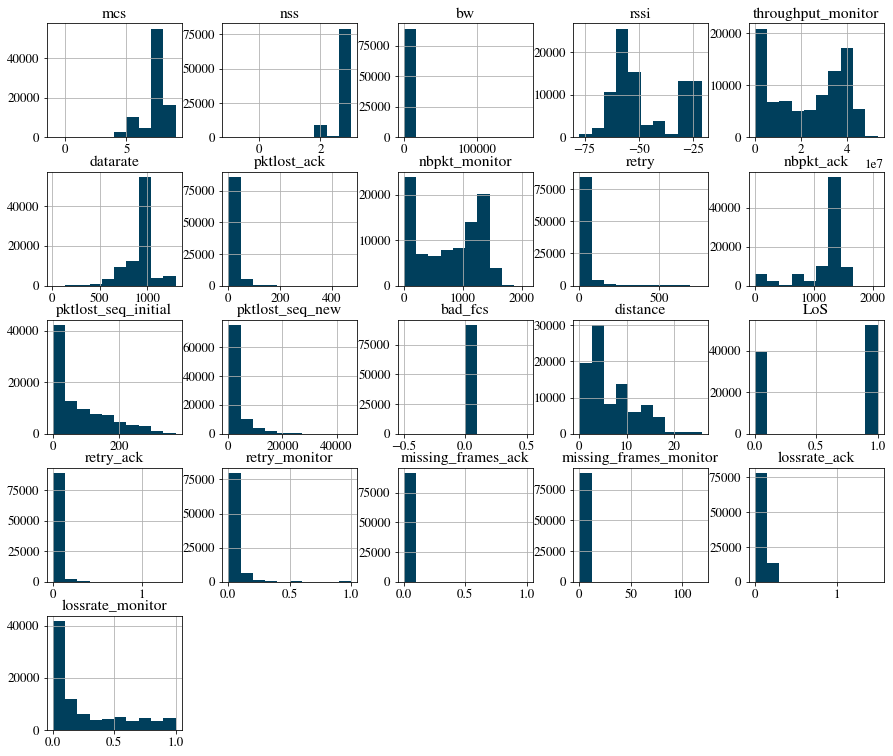

In [86]:
fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_all.drop('time', axis=1).hist(ax = ax)
plt.show()

We clean up the data a little bit so as to have more bounded metrics we can later use for performance evaluation and building a model. Most of the instances removed are the ones that have NaN values. These are usually the cases when only the ACKs are captured by the monitor and not the data frames. In such cases, it is impossible to calculate the MCS index, BW, NSS... because no data frames were present that allow to extract that information. We still keep these instances in the original data base in case we wish to use them later. 

<ipython-input-143-c30e97e958fa>:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_cleaned.hist(ax=ax)


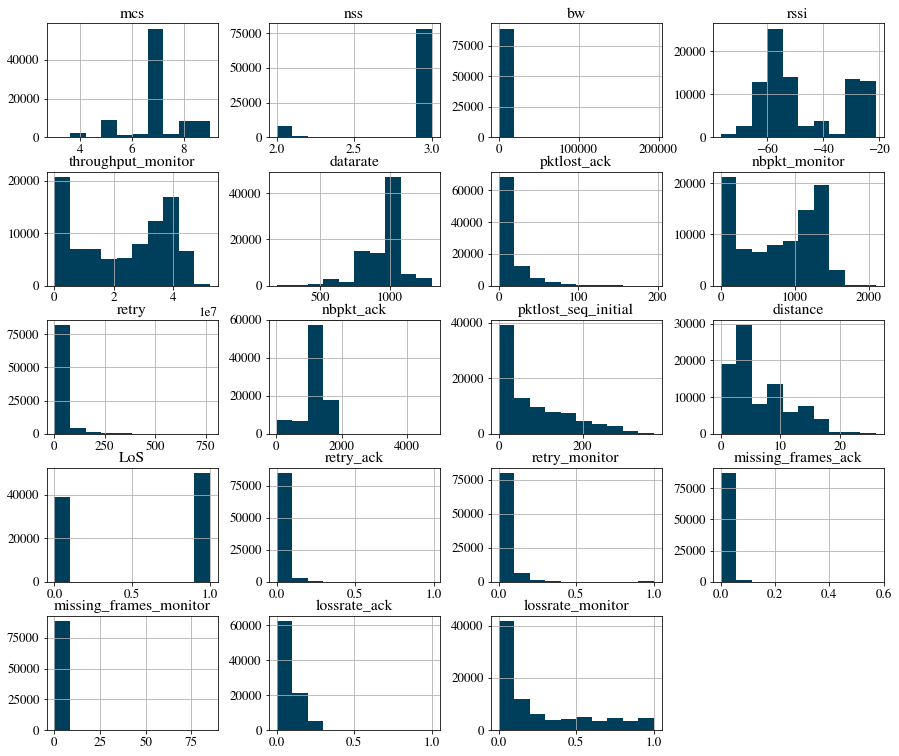

[              time      mcs      nss    bw     rssi  throughput_monitor  \
 0         8.100307  5.00000  3.00000  80.0 -62.0628          39374100.0   
 1         8.200425  5.00000  3.00000  80.0 -62.1569          37883600.0   
 2         8.300426  5.00000  3.00000  80.0 -62.1972          40036700.0   
 3         8.400429  5.00000  3.00000  80.0 -62.2085          39397100.0   
 4         8.500672  5.00000  3.00000  80.0 -62.4337          38501300.0   
 ...            ...      ...      ...   ...      ...                 ...   
 121666  126.601826  8.98281  2.00860  80.0 -62.5960          30791100.0   
 121667  126.701865  8.69565  2.14328  80.0 -62.8113          30283100.0   
 121668  126.803098  8.99162  2.00419  80.0 -62.5046          35170500.0   
 121669  126.915835  7.86344  2.56828  80.0 -63.5727           5976590.0   
 121670  127.023539      NaN      NaN   NaN      NaN                 NaN   
 
         datarate  pktlost_ack  nbpkt_monitor  retry  ...  distance  antenna  \
 0    

In [143]:
fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_cleaned = data_all.copy()
data_cleaned.dropna(inplace=True)
data_cleaned.drop(data_cleaned[data_cleaned['retry_ack'] > 1].index, axis=0, inplace=True)
data_cleaned.drop(data_cleaned[data_cleaned['missing_frames_ack'] > 1].index, axis=0, inplace=True)
data_cleaned.drop(data_cleaned[data_cleaned['lossrate_ack'] > 1].index, axis=0, inplace=True)
data_cleaned.drop(['bad_fcs', 'pktlost_seq_new'], axis=1, errors='ignore', inplace=True)
# print(len(data_all) - len(data_cleaned))
data_cleaned.hist(ax=ax)
data_cleaned.index = range(len(data_cleaned))
plt.show()
# print(len(data_cleaned))
data_copy = data_cleaned.copy()
data_copy['Scenario'] = 'All Data'
frames_with_data_all = [df1, df2, df3, df7, df8, df9, df11, data_copy]

**<h4>Choosing relevant performance metrics</h4>**

We now only have >100% loss when using the metric "missing_frames_monitor", i.e., the ratio between the number of lost frames as reported by the ACKs and the number of frames counted as being well received by the monitor. This is normal as we know that in many traces the monitor actually did not capture many frames that are later acknowledged in the BACKs, meaning that the communication was going well between the source and the destination, but the monitor missed it. 

The values that are reasonably bounded are the **retry_monitor** and **retry_ack** (the number of retries seen by the monitor divided by 1) the number of frames seen by the monitor or 2) the number of frames acknowledged in the BACKs), the **lossrate_monitor** and **lossrate_ack** (the number of missing sequence numbers (initial computation based on gaps) divided by 1) the number of frames seen by the monitor or 2) the number of frames acknowledged in the BACKs) and the **missing_frames_ack** (the number of missing frames in the BACKs and divided by the number of frames acknowledged in the BACKs).

**<h2>Correlations</h2>**

We look at [Pearson\'s](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), [Spearman's](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), and [Kendall's](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) correlation coefficients for linear and quadratic features. The goal is to find the features, or combinations of features, that correlate the most with the link quality metric we wish to predict.

The current code does only Pearson's, but simply change the "method" variable to "spearman" or "kendall".


In [9]:
from sklearn.preprocessing import PolynomialFeatures
def features_correlation_simple(X, Y_1, Y_2, scenario, label, degree=2, method = 'spearman', threshold = 0.0):
    # create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(X)
    # calculate correlation coefficients 
    poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(input_features=X.columns))
    poly_features[label[0]] = Y_1
    poly_features[label[1]] = Y_2
    poly_features['Scenario'] = scenario
    y1_corr = poly_features.corr(method=method)[label[0]]
    y2_corr = poly_features.corr()[label[1]]

    indexes = ([y1_corr.abs() >= threshold] or [y2_corr.abs() >= threshold])[0]
    y1_corr = y1_corr[indexes]
    y2_corr = y2_corr[indexes]

    sorted_index = y2_corr.abs().argsort()
    fig, ax = plt.subplots(figsize = (20,7))    
    x_axis = np.arange(len(y1_corr))
    ax.bar(x_axis-0.2, height=y1_corr[sorted_index].abs(), width=0.4, label=label[0])
    ax.bar(x_axis+0.2, height=y2_corr[sorted_index].abs(), width=0.4, label=label[1])

    plt.legend(loc='upper left')
    plt.xticks(x_axis, y1_corr.keys()[sorted_index], rotation=90)
    threshold = 0.5
    plt.axhline(threshold, ls='dotted', color=color9dgray, lw=4)
    return y1_corr, y2_corr

We only remove the features that are directly linked to the studied metric (i.e., the retry when studying the retry_monitor and so on).

In [11]:
# this threshold thing does not really work on both metrics so keep it set to 0.0 until I fix it
threshold = 0.0
method = 'pearson'

Text(0.5, 1.0, "Pearson's correlation coefficient")

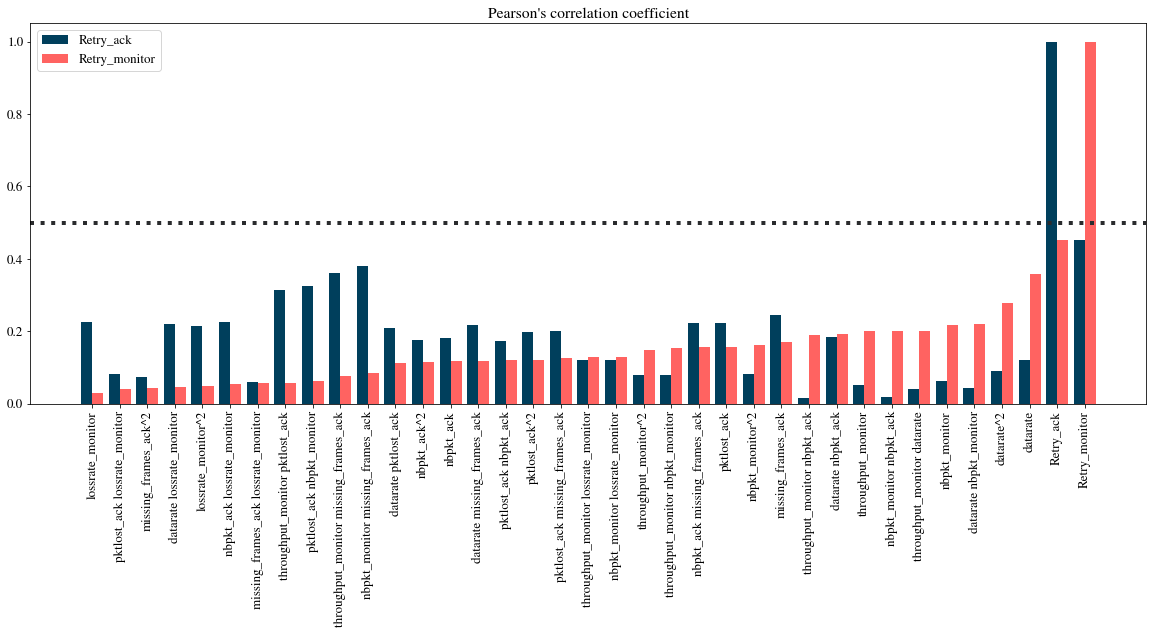

In [68]:
X = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'retry', 'retry_monitor', 'retry_ack', 'bw', 'LoS', 'rssi', 'lossrate_ack', 'distance', 'missing_frames_monitor', 'nss', 'mcs', 'pktlost_seq_initial', 'pktlost_seq_new'], axis=1, errors='ignore')
y_loss = 1-data_cleaned['retry_ack'].copy()
y_retry = 1-data_cleaned['retry_monitor'].copy()
y1_corr, y2_corr = features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned['Scenario'], label=['Retry_ack', 'Retry_monitor'], degree=2, method=method, threshold=threshold)
plt.title('Pearson\'s correlation coefficient')

Text(0.5, 1.0, "Pearson's correlation coefficient")

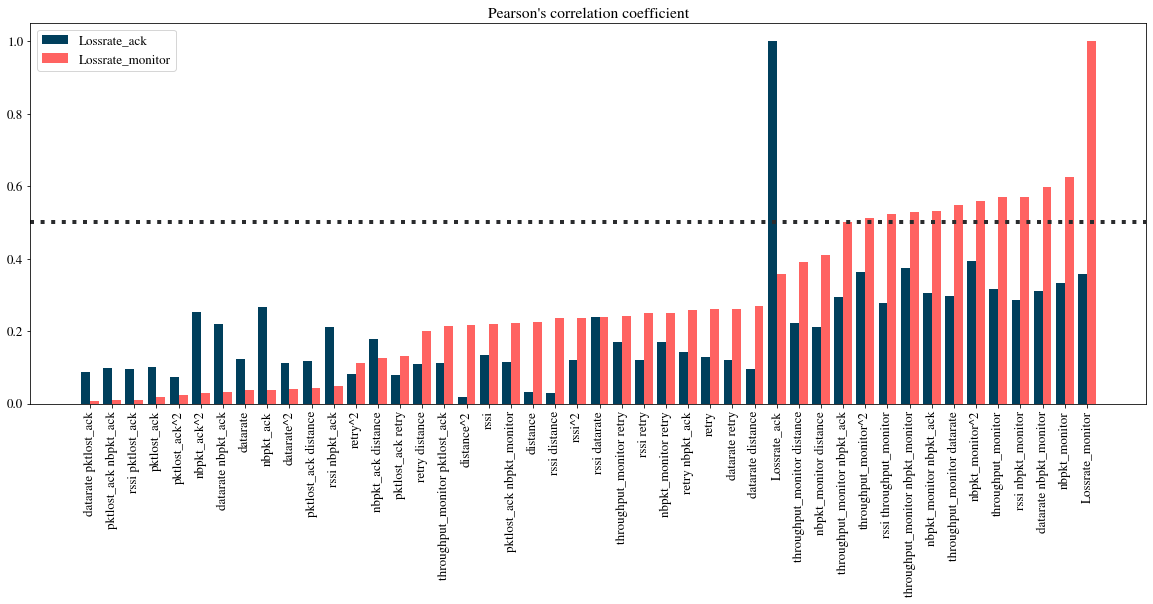

In [69]:
X = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'pktlost_seq_new', 'pktlost_seq_initial', 'lossrate_ack', 'lossrate_monitor', 'bw', 'LoS', 'missing_frames_monitor', 'nss', 'retry_monitor', 'missing_frames_ack', 'retry_ack', 'mcs'], axis=1, errors='ignore')
y_loss = data_cleaned['lossrate_ack'].copy()
y_retry = data_cleaned['lossrate_monitor'].copy()
features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned['Scenario'], label=['Lossrate_ack', 'Lossrate_monitor'], degree=2, method=method, threshold = threshold)
plt.title('Pearson\'s correlation coefficient')

Text(0.5, 1.0, "Pearson's correlation coefficient")

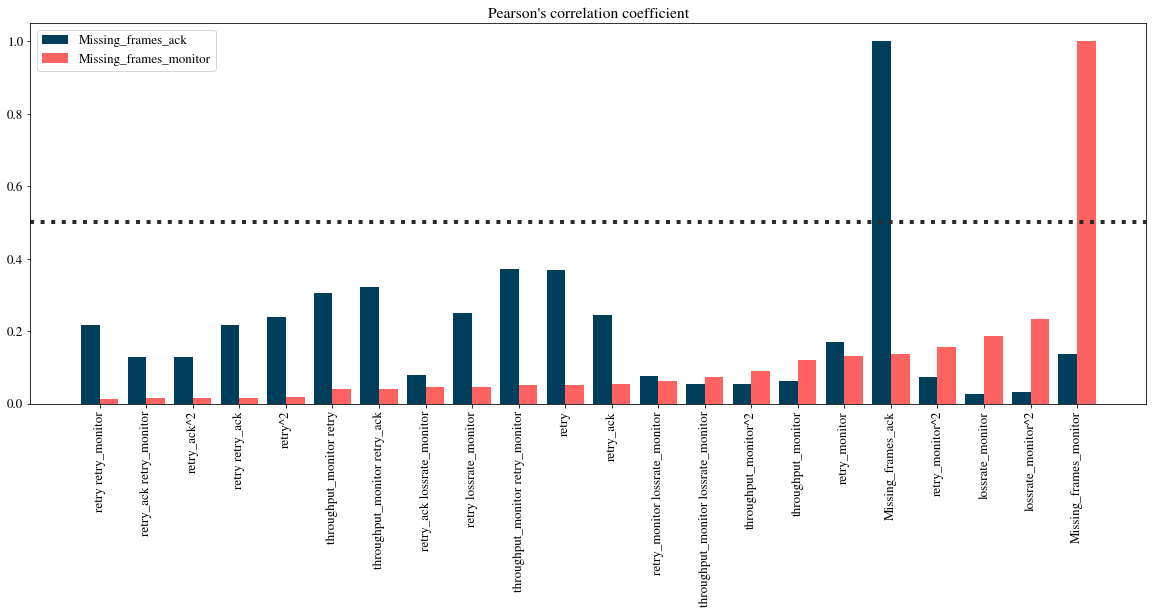

In [70]:
X = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'missing_frames_ack', 'missing_frames_monitor', 'pktlost_ack', 'bw', 'LoS', 'nss', 'distance', 'pktlost_seq_initial', 'rssi', 'datarate', 'mcs', 'nbpkt_monitor', 'lossrate_ack', 'nbpkt_ack'], axis=1, errors='ignore')
y_loss = data_cleaned['missing_frames_ack'].copy()
y_retry = data_cleaned['missing_frames_monitor'].copy()
features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned['Scenario'], label=['Missing_frames_ack', 'Missing_frames_monitor'], degree=2, method=method, threshold=threshold)
plt.title('Pearson\'s correlation coefficient')

<Figure size 1584x288 with 0 Axes>

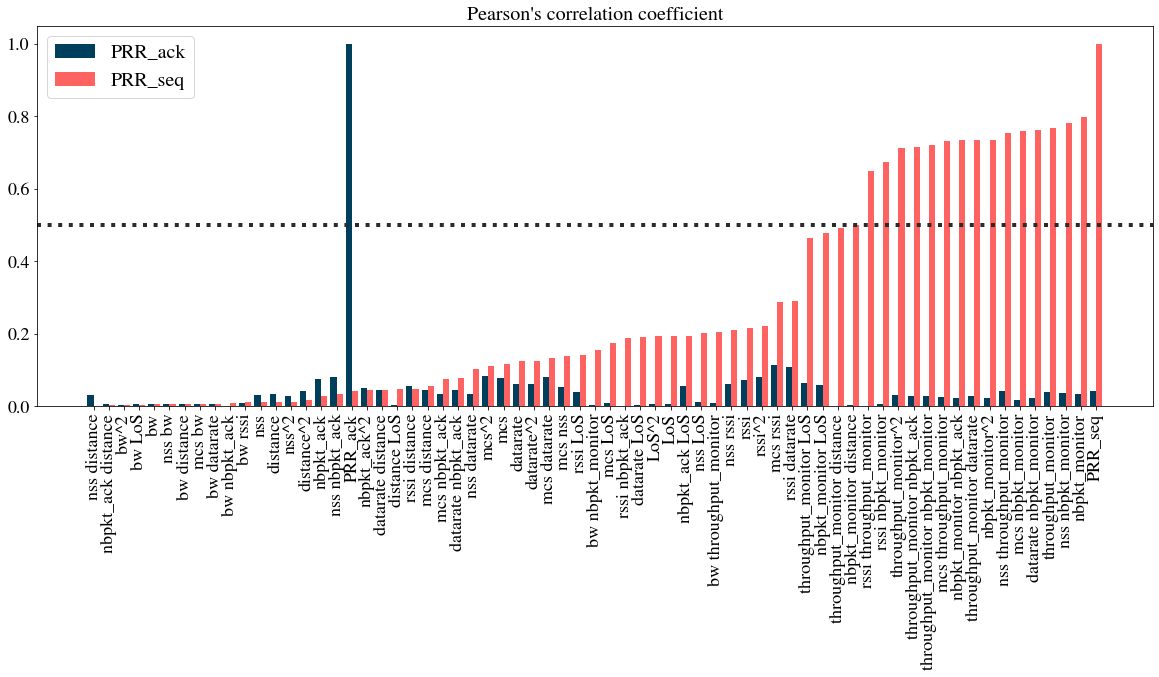

In [12]:
X = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'missing_frames_ack', 'lossrate_monitor', 'pktlost_ack', 'pktlost_monitor', 'retry', 'pktlost_seq_initial', 'pktlost_seq_new', 'lossrate_ack', 'missing_frames_monitor', 'retry_monitor', 'retry_ack'], axis=1, errors='ignore')
y_loss = data_cleaned['missing_frames_ack'].copy()
y_retry = data_cleaned['lossrate_monitor'].copy()
plt.figure(figsize=(22,4))
features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned['Scenario'], label=['PRR_ack', 'PRR_seq'], degree=2, method=method, threshold=threshold)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Pearson\'s correlation coefficient', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('figures/correlations_bar_graph.png', dpi=300, bbox_inches='tight')

In [13]:
def correlations_per_scenario(data, data_all, degree=2, metric = 'retry_monitor', type='pearson'):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(data)
    poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(input_features=data.columns))
    poly_features[metric] = 1 - data_all[metric]
    poly_features['Scenario'] = data_all['Scenario']
    correlation_complete = pd.DataFrame()
    for i in data_all['Scenario'].unique():
        a = pd.DataFrame(data=poly_features.loc[data_all['Scenario'] == i].corr(method=type)[metric])
        # a['Scenario'] = i
        # print(poly_features.loc[data_all['Scenario'] == i].corr()['retry_monitor'])
        correlation_complete = pd.concat([correlation_complete, a], axis=1)
    correlation_complete = correlation_complete.sort_index(axis=1)
    correlation_complete.columns = data_all['Scenario'].unique()
    return correlation_complete

**<h4>Correlation heatmaps per scenario</h4>**
The heatmaps only show selected features (chosen with trial and error using the previous histograms) so as to have legible figures. The goal here is to see if there are features that are more correlated with the performance metric in some scenarios than in others. We know for example that the anechoic data shows different tendencies from the corridor data (it is my opinion that this is for the moment only due to an unrepresentative dataset which is why I have excluded them from the current results here).

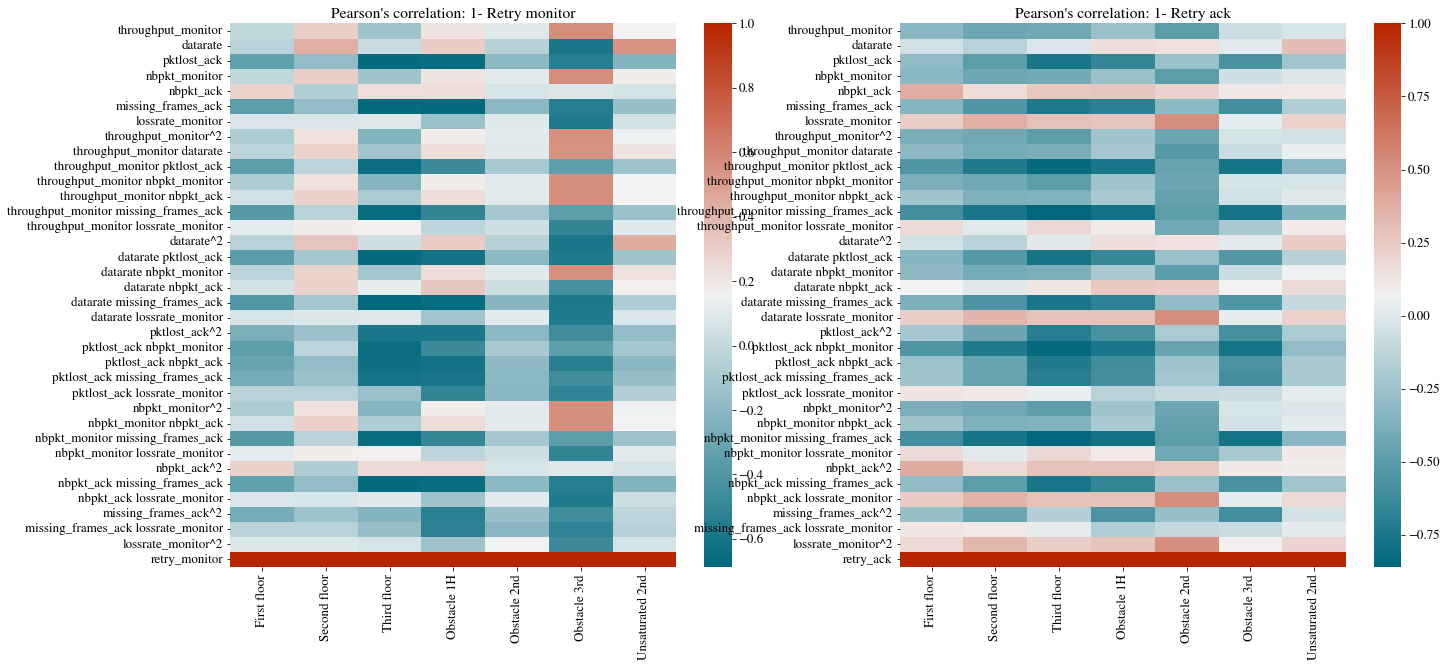

In [14]:
data_new = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'retry', 'retry_monitor', 'retry_ack', 'bw', 'LoS', 'rssi', 'lossrate_ack', 'distance', 'missing_frames_monitor', 'nss', 'mcs', 'pktlost_seq_initial', 'pktlost_seq_new'], axis=1, errors='ignore')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_cleaned, degree=2, metric='retry_monitor')
plt.figure(figsize=(22,10))
plt.subplot(1,2,1)
plt.title('Pearson\'s correlation: 1- Retry monitor')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.subplot(1,2,2)
plt.title('Pearson\'s correlation: 1- Retry ack')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_cleaned, degree=2, metric='retry_ack')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()

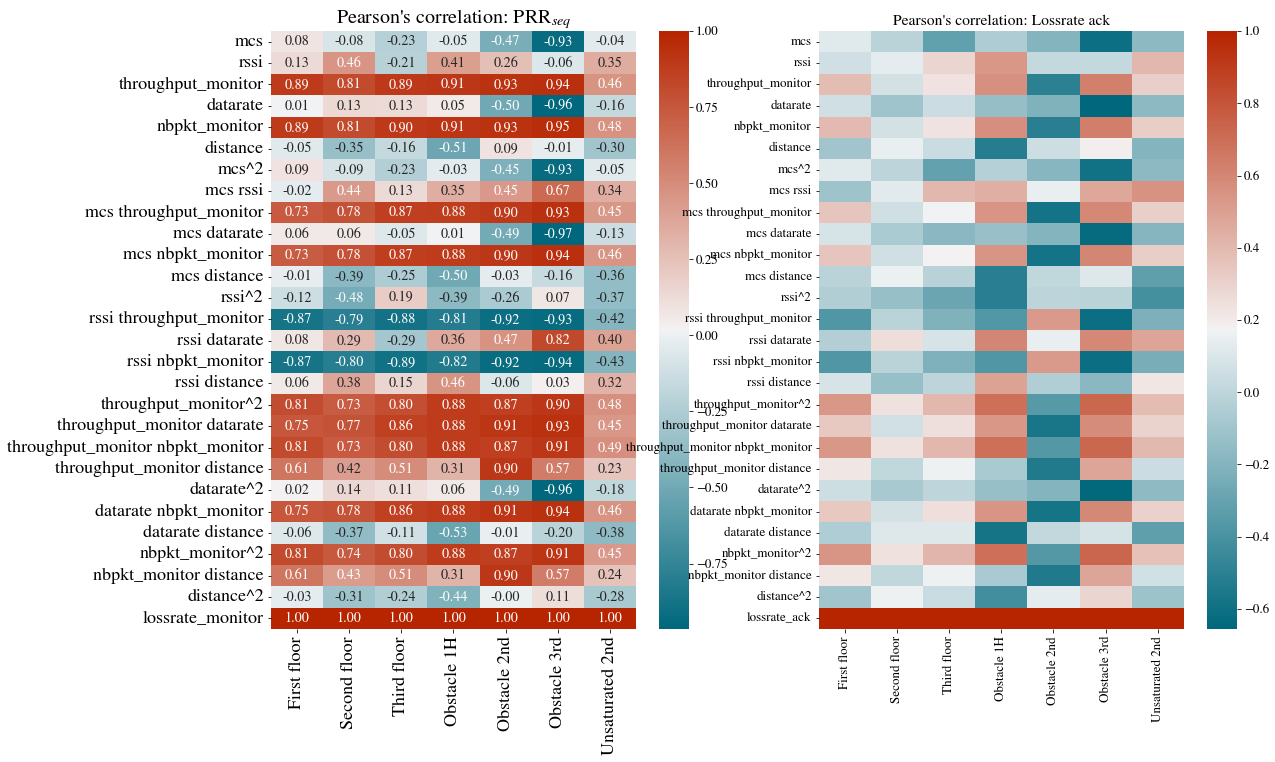

In [30]:
data_new = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'pktlost_seq_initial', 'pktlost_seq_new', 'retry_monitor','retry_ack','retry', 'bw', 'LoS', 'nss', 'pktlost_ack', 'lossrate_monitor', 'lossrate_ack', 'nbpkt_ack', 'missing_frames_monitor', 'missing_frames_ack'], axis=1, errors='ignore')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_cleaned, degree=2, metric='lossrate_monitor')
plt.figure(figsize=(18,11))
plt.subplot(1,2,1)
plt.title('Pearson\'s correlation: PRR$_{seq}$', fontsize=20)
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True), annot=True, fmt='.2f',annot_kws={"fontsize":14})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('figures/prr_seq.png', dpi=300, bbox_inches='tight')
plt.subplot(1,2,2)
plt.title('Pearson\'s correlation: Lossrate ack')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_cleaned, degree=2, metric='lossrate_ack')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()

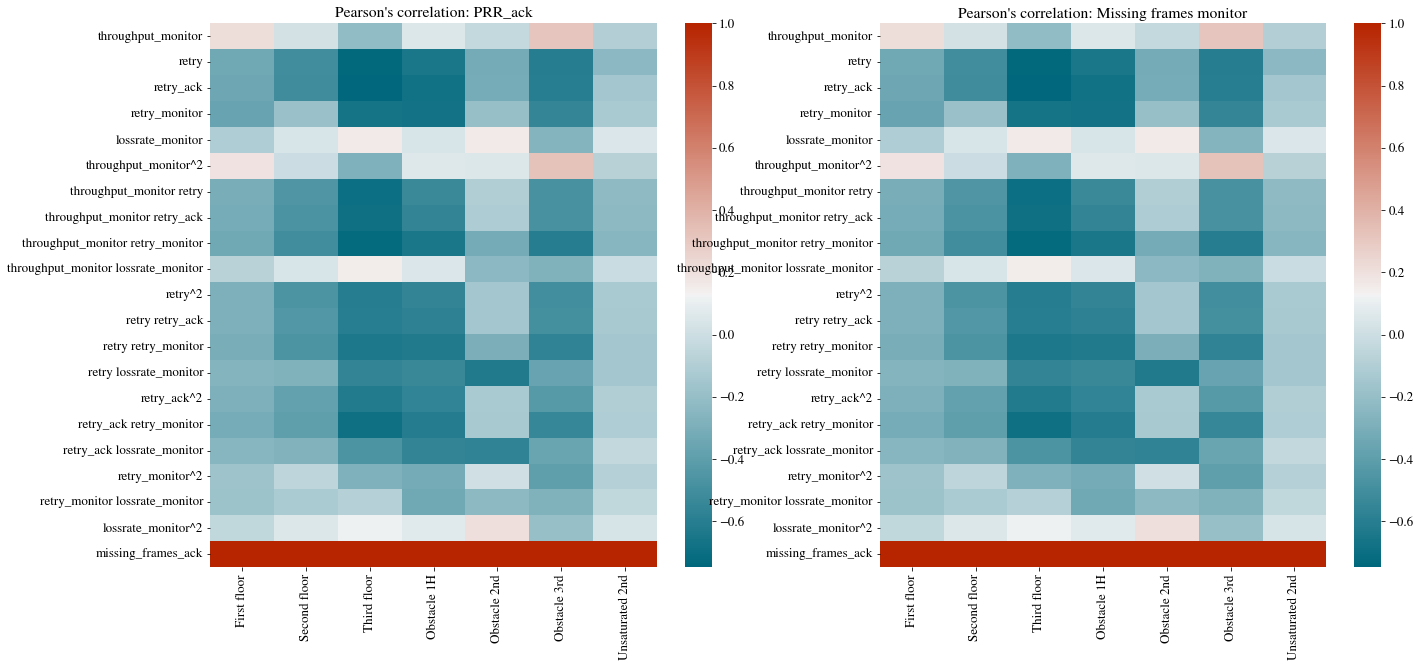

In [75]:
data_new = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'missing_frames_ack', 'missing_frames_monitor', 'pktlost_ack', 'bw', 'LoS', 'nss', 'distance', 'pktlost_seq_initial', 'rssi', 'datarate', 'mcs', 'nbpkt_monitor', 'lossrate_ack', 'nbpkt_ack'], axis=1, errors='ignore')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_cleaned, degree=2, metric='missing_frames_monitor')
plt.figure(figsize=(22,10))
plt.subplot(1,2,1)
plt.title('Pearson\'s correlation: PRR_ack')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_cleaned, degree=2, metric='missing_frames_ack')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.savefig('figures/prr_ack.png', dpi=300, bbox_inches='tight')
plt.subplot(1,2,2)
plt.title('Pearson\'s correlation: Missing frames monitor')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()

**<h4>Correlation conclusions</h4>**

**Retry rate** (retries/nb frames captured by monitor or retries/nb frames acknowledged in BACKs)
<li>It will likely be difficult to build a precise prediction model. All correlation coefficients show very weak links between the retry rate and any other features. It is less true for specific scenarios, i.e., the 3rd floor with obstacle, but this particular data set seems to be an outlier in all the correlation studies so far. </li>


**Lossrate_monitor** (number of missing frames (sequence number gaps)/nb frames captured by monitor)
<li>The correlations here are much stronger, and they are consisetent with what we have seem before, meaning that the most imprtant features seem to be the nbpkt_monitor, datarate, and throughput_monitor. We weill first build a model using only these features and see if anything needs to be added</li>


**Lossrate_ack** (number of missing frames (sequence number gaps)/number frames acknowledged in BACKs)
<li>The correlations here are very week, but it's not surprising. We are comparing the number of frames missed b the monitor with the number of frames acknowledged by the BACKs, i.e., one quantity related to what the source sends and one linked to what the destination sends. It is reasonable then that these two quantities will not necessarily result in something that accurately predicts the behaviour of the network.</li>


**Missing frames monitor**
<li>This one can be completely ignored: it has the same issue as lossrate_ack and it is not even properly bounded in [0,1]. Other features had to be bounded in the clean-up phase, but bounding this one would require removing a significant and unjustifiably large portion of the data.</li>


**Missing frames ack**
<li>This one seems to not correlate with anything either.</li>


<h2>Building the model</h2>

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

linear_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()), 
            ("regressor", LinearRegression()),]
)
poly_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler()), 
            ("regressor", LinearRegression()),]
)

def calculate_model(X_train, y_train, cv = 5, model_kargs = np.arange(0.5,5.5,0.5)):
    
    linear_pipe = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()), 
                ("Ridge", Ridge()),
            ]
    )
    grid_linear = GridSearchCV(linear_pipe, param_grid=model_kargs, cv=cv, scoring='neg_mean_absolute_error')
    grid_linear.fit(X_train, y_train)
   

    poly_pipe = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")),
                ("poly", PolynomialFeatures(degree=2, include_bias=False)),
                ("scaler", StandardScaler()), 
                ("Ridge", Ridge()),
            ]
    )
    grid_poly = GridSearchCV(poly_pipe, param_grid=model_kargs, cv=cv, scoring='neg_mean_absolute_error')
    grid_poly.fit(X_train, y_train)

    # # calculate sorted coefficients
    # feature_names = poly_model.named_steps['poly'].get_feature_names_out(input_features=X_train.columns.append(antenna_names))
    # feature_coefs = poly_model.named_steps['regressor'].coef_
    # sorted_indexes = abs(feature_coefs).argsort()
    # sorted_coef_poly = np.c_[feature_names[sorted_indexes], feature_coefs[sorted_indexes]]
    return grid_linear,  grid_poly


In [70]:
def plot_model(grid_linear, grid_poly, X_test, y_test):
    from sklearn.metrics import r2_score
    y_predict_linear = grid_linear.predict(X_test)
    y_predict_poly = grid_poly.predict(X_test)

    plt.rcParams["figure.figsize"] = (5,7)
    plt.figure(1)
    plt.grid()
    sns.scatterplot(x=y_test, y=y_predict_linear, alpha=0.3, s=40, linewidth=0.1, hue=hue_markers, palette=colorlist_summer_divergent[0:len(hue_markers.unique())])
    plt.plot(y_test, y_test, label='Ideal', c='k')
    plt.xlabel('Groud truth', fontsize=20)
    plt.ylabel('Prediction', fontsize=20)        
    plt.legend(loc='lower right', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim([-0.2, 1.2])
    plt.xlim([-0.2, 1.2])
    

    plt.figure(2)
    plt.grid()
    sns.scatterplot(x=y_test, y=y_predict_poly, alpha=0.3, s=40, linewidth=0.1, hue=hue_markers, palette = colorlist_summer_divergent[0:len(hue_markers.unique())])
    plt.plot(y_test, y_test, label='Ideal', c='k')
    plt.xlabel('Groud truth', fontsize=20)
    plt.ylabel('Prediction', fontsize=20)
    plt.legend(loc='lower right', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)        
    plt.ylim([-0.2, 1.2])

    r2_linear = r2_score(y_true=y_test, y_pred=y_predict_linear)
    r2_poly = r2_score(y_true=y_test, y_pred=y_predict_poly)
    mae_linear = mean_absolute_error(y_test, y_predict_linear)
    mae_poly = mean_absolute_error(y_test, y_predict_poly)
    rmse_linear = mean_squared_error(y_test, y_predict_linear, squared=False)
    rmse_poly = mean_squared_error(y_test, y_predict_poly, squared=False)

    print("Linear and poly R2 scores: ", r2_linear, r2_poly)
    print("Linear and poly mean absolute error: ", mae_linear, mae_poly)
    print("Linear and poly RMSE: ", rmse_linear, rmse_poly)
        
    return y_predict_linear, y_predict_poly, r2_linear, r2_poly, mae_linear, mae_poly, rmse_linear, rmse_poly


**<h4>Lossrate</h4>**
The lossrate here is the ratio between the number of frames counted as missing (using the initial computation based on the missing sequence numbers where we only record the event that a loss occured, but we do not know if it is a single frame or several) and the number of frames captured by the monitor.

Linear and poly R2 scores:  0.5957554593213139 0.6429443451398438
Linear and poly mean absolute error:  0.1340737752611234 0.12783647294875491
Linear and poly RMSE:  0.19554891807131136 0.18378128910887456


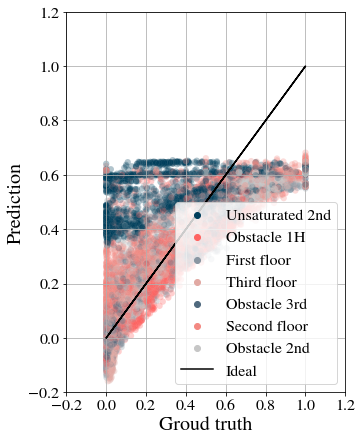

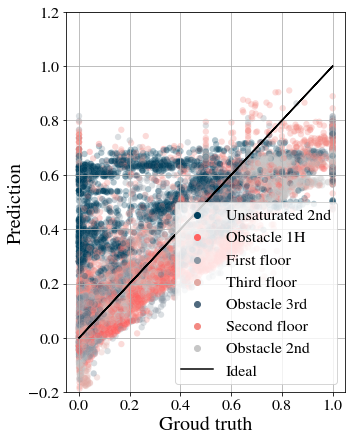

In [135]:
from sklearn.model_selection import StratifiedShuffleSplit
features = ['mcs', 'rssi', 'throughput_monitor', 'nbpkt_monitor', 'datarate', 'distance']
metric = 'lossrate_monitor'
# X = data_cleaned.drop(['time', 'retry', 'retry_ack', 'retry_monitor', 'Scenario', 'LoS', 'antenna', 'mcs', 'nss', 'bw', 'throughput_monitor', 'pktlost_seq_initial'], axis=1, errors='ignore')
X = data_cleaned[features]
y = data_cleaned['lossrate_monitor'].copy()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
bins = np.linspace(0, len(data_cleaned) , 20)
y_binned = np.digitize(y, bins)
for train_index, test_index in split.split(data_cleaned, y_binned):
    hue_markers = data_cleaned['Scenario'].loc[test_index]
    X_train_all = X.loc[train_index]
    X_test_all = X.loc[test_index]
    y_train_all = y.loc[train_index]
    y_test_all = y.loc[test_index]

grid_linear_all, grid_poly_all =  calculate_model(X_train_all, y_train_all, cv=5, model_kargs={'Ridge__alpha':np.arange(0.5,10.5,0.5)})
y_predict_linear_all, y_predict_poly_all, r2_linear_all, r2_poly_all, mae_linear_all, mae_poly_all, rmse_linear_all, rmse_poly_all = plot_model(grid_linear=grid_linear_all, grid_poly=grid_poly_all, X_test=X_test_all, y_test=y_test_all)

<h4>Lossrate model per scenario</h4>

In [157]:
features = {
    'First floor' : ['throughput_monitor', 'nbpkt_monitor'],
    'Second floor' : ['throughput_monitor', 'nbpkt_monitor', 'rssi'],
    'Third floor' : ['throughput_monitor', 'nbpkt_monitor'],
    'Obstacle 1H' : ['throughput_monitor', 'nbpkt_monitor', 'rssi', 'distance', ],
    'Obstacle 2nd' : ['throughput_monitor', 'nbpkt_monitor', 'mcs', 'datarate'],
    'Obstacle 3rd' : ['throughput_monitor', 'nbpkt_monitor', 'mcs', 'datarate'],
    'Unsaturated 2nd' : ['throughput_monitor', 'nbpkt_monitor'],
    'All Data' : ['mcs', 'rssi', 'throughput_monitor', 'nbpkt_monitor', 'datarate', 'distance']
}

In [ ]:
def calc_errors(X_test, y_test, grid_linear, grid_poly):
    from sklearn.metrics import r2_score
    
    y_predict_linear = grid_linear.predict(X_test)
    y_predict_poly = grid_poly.predict(X_test)
    r2_linear = r2_score(y_true=y_test, y_pred=y_predict_linear)
    r2_poly = r2_score(y_true=y_test, y_pred=y_predict_poly)
    mae_linear = mean_absolute_error(y_test, y_predict_linear)
    mae_poly = mean_absolute_error(y_test, y_predict_poly)
    rmse_linear = mean_squared_error(y_test, y_predict_linear, squared=False)
    rmse_poly = mean_squared_error(y_test, y_predict_poly, squared=False)

    return y_predict_linear, y_predict_poly, r2_linear, r2_poly, mae_linear, mae_poly, rmse_linear, rmse_poly


In [167]:
def mix_match_scenarios(frames, data=data_cleaned, cv=5, model_kargs={'Ridge__alpha':np.arange(0.5,10.5,0.5)}):
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    mae = {}
    rmse = {}
    r2_score = {}
    grid_poly = {}
    grid_linear = {}
    y_predict_linear = {}
    y_predict_poly = {}
    data.index = range(len(data))

    # we first just generate the train/test sets, just makes it easier to read even if not optimal
    for i in range(len(frames)):
        scenario = frames[i]['Scenario'][0]
        features_scenario = features[scenario]
        metric = 'lossrate_monitor'
        X = data[features_scenario]
        y = data['lossrate_monitor'].copy()

        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        bins = np.linspace(0, len(data) , 20)
        y_binned = np.digitize(y, bins)

        for train_index, test_index in split.split(data, y_binned):
            hue_markers = data['Scenario'].loc[test_index]
            X_train[scenario] = X.loc[train_index]
            X_test[scenario] = X.loc[test_index]
            y_train[scenario] = y.loc[train_index]
            y_test[scenario] = y.loc[test_index]

    for i in range(len(frames)):
        scenario_train = frames[i]['Scenario'][0]
        grid_linear[scenario_train], grid_poly[scenario_train] =  calculate_model(X_train[scenario_train], y_train[scenario_train], cv=cv, model_kargs=model_kargs)
        for j in range(len(frames)):
            scenario_test = frames[i]['Scenario'][0]
            y_predict_linear[scenario_test], y_predict_poly, r2_linear_all, r2_poly_all, mae_linear_all, mae_poly_all, rmse_linear_all, rmse_poly_all = plot_model(grid_linear=grid_linear_all, grid_poly=grid_poly_all, X_test=X_test_all, y_test=y_test_all, plot=0)

    return grid_poly, grid_linear, mae, r2_score, rmse

mix_match_scenarios(frames=frames_with_data_all, data = pd.concat([data_cleaned, data_copy]), cv=2, model_kargs={'Ridge__alpha':np.arange(0.5,10.5,2)})

({}, {}, {}, {}, {})

In [140]:
def plot_heatmaps(score, rmse, mae, names, color_map = cmap_summer_divergent, linew = 0.5):
    plt.figure(num=1, figsize=(6,5))
    plt.title('Mean absolute error')
    sns.heatmap(mae, cmap = color_map, linewidths=linew, xticklabels=names, yticklabels=names, vmax=0.5, annot=True, fmt='.2f')
    plt.savefig('figures/mae.png', dpi=200, bbox_inches='tight')
    
    plt.figure(num=3, figsize=(6,5))
    plt.title('Root mean square error')
    sns.heatmap(rmse, cmap = color_map, linewidths=linew, xticklabels=names, yticklabels=names, vmax=0.5, annot=True, fmt='.2f')
    plt.savefig('figures/rmse.png', dpi=200, bbox_inches='tight')
    
    plt.figure(num=5, figsize=(6,5))
    plt.title('R2 score')
    sns.heatmap(score, cmap = color_map, linewidths=linew, xticklabels=names, yticklabels=names, vmin=0, vmax = 1.0, annot=True, fmt='.2f')
    plt.savefig('figures/r2_score.png', dpi=200, bbox_inches='tight')

Mean MAE 
 First floor        0.135441
Second floor       0.153663
Third floor        0.322158
Obstacle 1H        0.143282
Obstacle 2nd       0.698605
Obstacle 3rd       1.106379
Unsaturated 2nd    0.663701
All Data           0.129197
dtype: float64
Mean RMSE 
 First floor        0.184741
Second floor       0.205471
Third floor        0.393535
Obstacle 1H        0.187283
Obstacle 2nd       0.810759
Obstacle 3rd       1.402588
Unsaturated 2nd    0.746739
All Data           0.169898
dtype: float64
Mean R2 
 First floor       -0.294339
Second floor      -1.599123
Third floor       -2.556392
Obstacle 1H       -0.411940
Obstacle 2nd      -6.085286
Obstacle 3rd      -2.080367
Unsaturated 2nd   -0.995890
All Data          -0.219205
dtype: float64


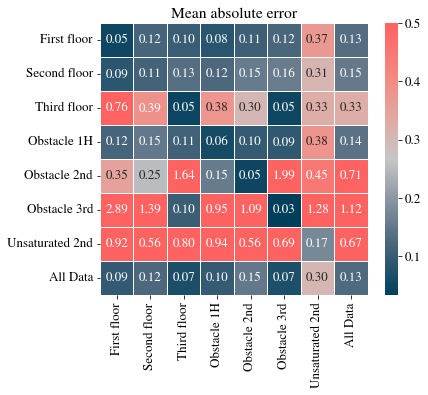

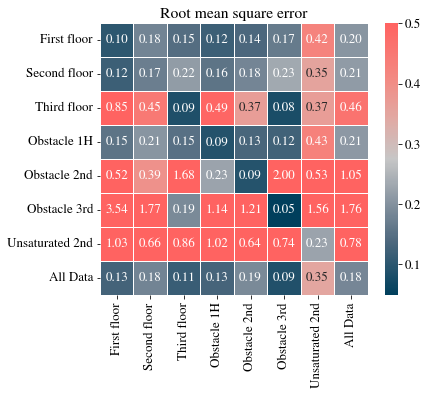

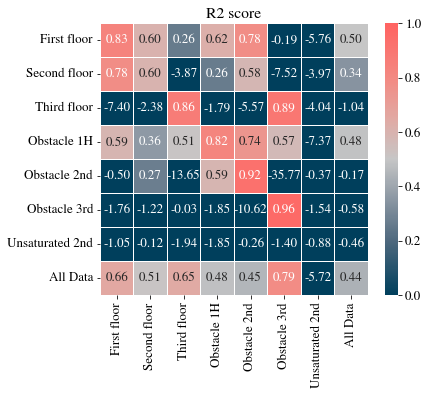

In [141]:
plot_heatmaps(r2_poly, rmse_poly, mae_poly, names=rmse_poly.index)
summary = pd.DataFrame()

print('Mean MAE \n', mae_poly.transpose().mean())
print('Mean RMSE \n', rmse_poly.transpose().mean())
print('Mean R2 \n', r2_poly.transpose().mean())

<h4>Mix and match conclusions</h4>
The biggest outlier is the unsaturated case. In order to make sure that there is not some feature that is super important in this case that we've removed, we look at the correlations for this scenario alone. In turns out, both Spearman's and Pearson's correlations are really weak and no conclusive linear model can be derived (which is nbious when we see that we get an R2 score of 0.6).

In [194]:
X = df11.drop(['time', 'Scenario', 'antenna', 'bad_fcs'], axis=1, errors='ignore')
X.dropna(inplace=True)
y_retry = X['lossrate_monitor'].copy()
X.drop(['lossrate_monitor'], axis=1, inplace=True)
features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned['Scenario'], label=['Lossrate_ack', 'Lossrate_monitor'], degree=2, method='spearman', threshold=threshold)
plt.title('Pearson\'s correlation coefficient')

KeyboardInterrupt: 

<h4>To do:</h4>


~~Do a mix and match with training data and testing data.~~

~~Change the size of the datasets so that they are all compatible with the smallest one.~~

~~Models without the 3rd floor obstacle and the anechoic chamber data.~~

~~Add the unsaturated data.~~

Do a distribution test to see what's going on with the data on the 3rd floor with obstacle.

~~Cross-validation and grid search for the parameters.~~